# Visualizing Ubuntu Failed Login Attempt

This script visualise /var/log/auth.log file on ubuntu using regular expresion

#### Requirement:
- python-geoip
- python-geoip-geolite2
- matplotlib
- numpy
- seaborn
- pandas
- wordcloud
- ipyleaflet

#### Open & Read File

In [1]:
with open('auth.log') as f:
    d = f.readlines()

#### Make a simple class

In [2]:
import datetime
from geoip import geolite2
import json


class LoginAttempt:
    country_code = "Unknown"
    lat = None
    lng = None
    dayname = None
    hour = None
    
    def __init__(self, timestamp, username, ip_address):
        self.timestamp = timestamp
        self.username = username
        self.ip_address = ip_address
        self.lookup_ip(ip_address)
        self.dayname = datetime.datetime.strptime(timestamp, "%b %d %H:%M:%S").strftime("%a")
        self.hour = datetime.datetime.strptime(timestamp, "%b %d %H:%M:%S").strftime("%H")
        
    def get_datetime_object(self):
        return datetime.datetime.strptime(self.timestamp, "%b %d %H:%M:%S")
    
    def get_datetime_format(self, fmt = None):
        if fmt:
            return fmt.format(self.get_datetime_object())
        return "{0:%d/%m %H:%M:%S}".format(self.get_datetime_object())
    
    def lookup_ip(self, ip):
        match = geolite2.lookup(ip)
        if match:
            self.country_code = match.country
            if match.location:                
                self.lat = list(match.location)[0]
                self.lng = list(match.location)[1]
    
    """
    " Debug function
    """
    def to_JSON(self):
        return json.dumps(self, default=lambda o: o.__dict__, 
            sort_keys=True, indent=4)
    
    def dict_from_class(cls):
        return dict((key, value) for (key, value) in cls.__dict__.items())


#### Regular Expression
Self explaination

In [3]:
import re
def get_error_login(line):
    pattern = re.compile(r"""
        ([^\s]+         #Month
        \s              #<space>
        \d{1,31}        #Date
        \s              #<space>
        \d\d:\d\d:\d\d) #Hour:Minute:Second
        \s              #<space>
        [^\s]+          #Server name
        \s              #<space>
        sshd\[          #detect if the log is sshd
        .*\]:\s         #Content delimiter
        Invalid\suser   #Main keyword
        \s              #<space>
        ([^\s]+)        #Username
        \sfrom\s
        (\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}) #IPAddress
        
        """, re.VERBOSE)
    
    match = re.match(pattern, line)
    if match:
        g = match.groups()
        obj = LoginAttempt(g[0], g[1], g[2])
        return obj
    else:
        return None

#### Iteration and DataFrame creation

In [5]:
import pandas as pd
attempts = []

for line in d:
    obj = get_error_login(line)
    if obj:
        attempts.append(obj.dict_from_class())

df = pd.DataFrame(attempts)
df.head()

,country_code,dayname,hour,ip_address,lat,lng,timestamp,username
0,FR,Sat,07,37.187.107.54,48.86,2.35,Mar 31 07:35:28,to
1,FR,Sat,07,37.187.107.54,48.86,2.35,Mar 31 07:38:29,mathias
2,FR,Sat,07,195.154.60.218,48.86,2.35,Mar 31 07:40:53,admin
3,FR,Sat,07,195.154.60.218,48.86,2.35,Mar 31 07:41:00,default
4,FR,Sat,07,195.154.60.218,48.86,2.35,Mar 31 07:41:04,ubnt


#### Heatmap
Visualize the login attempt pattern in days and hours

Text(0.5,1,'Login Attempt by Day by Hour')

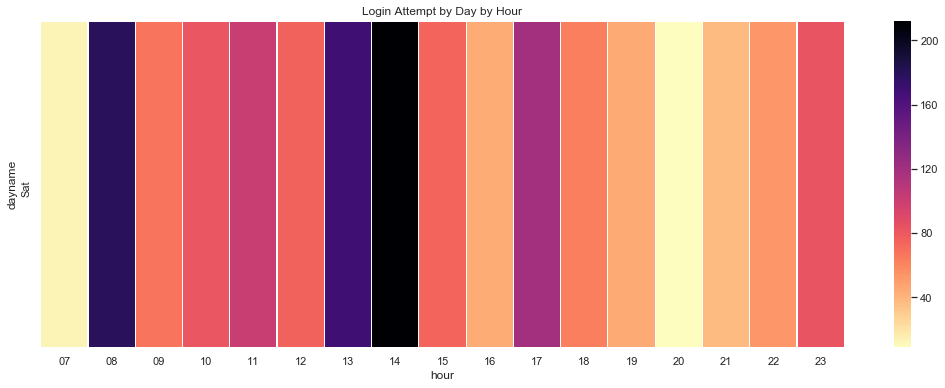

In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
import seaborn as sns
sns.set()

days = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]
hours = ["00", "01", "02", "03", "04", "05", "06", "07", "08", "09", "10",
          "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23"]

cat_type = CategoricalDtype(categories=days, ordered=True)
df['dayname'] = df['dayname'].astype(cat_type)

cdata = df.groupby(['dayname', 'hour']).count()

attempt_data = cdata.pivot_table(values='ip_address', index="dayname", columns='hour', aggfunc='first')
f, ax = plt.subplots(figsize=(18, 6))
sns.heatmap(attempt_data, linewidths=.1, ax=ax, square=False, cmap="magma_r").set_title("Login Attempt by Day by Hour")


#### Get Top 20 Origin country

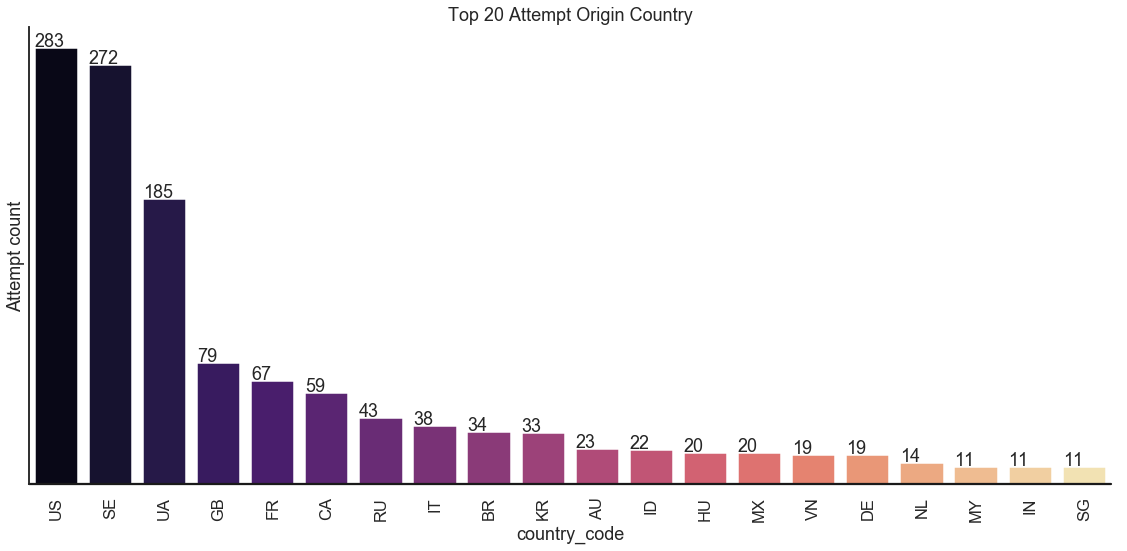

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white", context="talk")
rs = np.random.RandomState(8)

# Set up the matplotlib figure
f, ax1 = plt.subplots(1, 1, figsize=(16, 8), sharex=True)

cdata = df.groupby('country_code').count().sort_values('ip_address', ascending=False).head(n=20)

x = cdata.index
y1 = cdata["ip_address"].values.tolist()
bars = plt.bar(x, height=y1, width=.0001)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() - 0.4, yval + 1, yval)
sns.barplot(x=x, y=y1, palette="magma", ax=ax1).set_title("Top 20 Attempt Origin Country")
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Attempt count")
ax1.set_xticklabels(x, rotation=90)

# Finalize the plot
sns.despine(bottom=True)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

#### Most common username that has been attempted

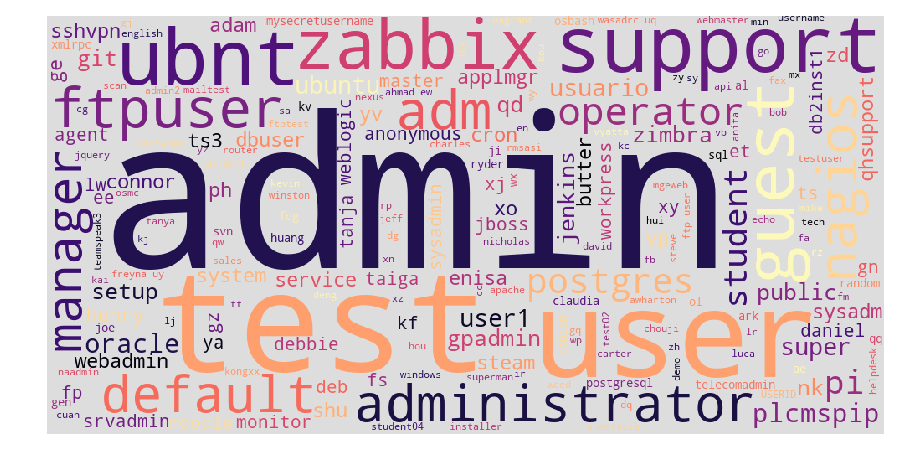

In [9]:
from wordcloud import WordCloud
%matplotlib inline

w = ' '.join(df['username'].tolist())

wordcloud = WordCloud(
        width = 1000, 
        height = 500,
        background_color = "#ddd",
        colormap="magma"
    ).generate(w)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Visualize Origin Coordinate
##### NOTE! Please change the target_location with your location

In [10]:
from ipyleaflet import Map, basemaps, basemap_to_tiles, Polyline
import random

#Change with your server coordinate
target_location = (-0.789275, 113.921327)
m = Map(center=target_location, zoom=1)

def add_line(m, coordinate, opacity):
    c = ["#ff1000","#ffa000","#aff000"]
    line = Polyline(
        locations = [
                    list(target_location),
                    coordinate
        ],
        color = random.choice(c),
        fill=False,
        opacity=opacity,
        weight=1
        
    )
    m.add_layer(line)
    
dark_matter_layer = basemap_to_tiles(basemaps.CartoDB.DarkMatter)
m.add_layer(dark_matter_layer)

location = df.groupby(['lat', 'lng']).count()
location.head(n=20)
for i, v in location.iterrows():
    if(v[0] and v[1]):
        op = v["ip_address"] / 1000
        if op >= 1:
            op = 0.8
        elif op <= 0:
            op = 0.4

        add_line(m, [v[0], v[1]], op)
m

TWFwKGJhc2VtYXA9eyd1cmwnOiAnaHR0cHM6Ly97c30udGlsZS5vcGVuc3RyZWV0bWFwLm9yZy97en0ve3h9L3t5fS5wbmcnLCAnbWF4X3pvb20nOiAxOSwgJ2F0dHJpYnV0aW9uJzogJ01hcCDigKY=
